In [0]:
import numpy as np
import pandas as pd
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/train.csv',index_col="tripid")

In [0]:
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct


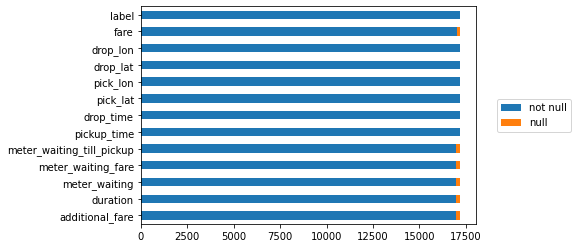

In [0]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

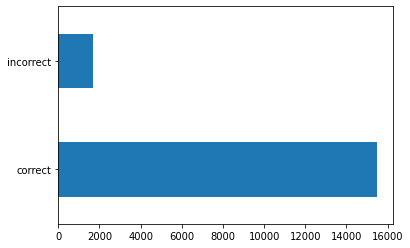

In [0]:
train_df['label'].value_counts().plot.barh()

In [0]:
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

RANDOM_SEED = 42  

SyntaxError: ignored

In [0]:
labels_raw_df = train_df.loc[:, train_df.columns == 'label']
features_raw_df = train_df.drop(columns=['label'])

In [0]:
def preprocess_labels(input_labels_df):
  labels_df = input_labels_df
  labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
  
  labels_df.columns = labels_df.columns
  labels_df.index = labels_df.index

  return labels_df  

In [0]:
labels_df = preprocess_labels(labels_raw_df)

In [0]:
def preprocess_features(input_features_df):
  features_df = input_features_df.copy()
  numeric_cols = features_df.columns[features_df.dtypes != "object"].values 
  non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values

  #numeric
  #scale features
  scaler = RobustScaler()
  features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

  #impute missing values
  imputer = KNNImputer()
  features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

  #date time
  features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
  features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
  
  #get day of the week
  features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
  features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
  
  features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
  features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60

  #encode cyclic 24 hours with sin and cos
  features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
  features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

  features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
  features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)

  #get weekday or weekend
  weekenddays = ['Saturday', 'Sunday']

  features_df['pickup_weekday'] = np.where(features_df['pickup_day_of_week'].isin(weekenddays), 0, 1)
  features_df['drop_weekday'] = np.where(features_df['drop_day_of_week'].isin(weekenddays), 0, 1)
  
  features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
  
  features_df = features_df.drop(columns=['pickup_time','drop_time'])
  
  return features_df

In [0]:
features_df = preprocess_features(features_raw_df)
features_df.shape

(17176, 32)

In [0]:
x_train, x_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
def sequential_model():
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(56, activation=tf.nn.relu),
	  keras.layers.Dense(28, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1])
  return model

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

model = KerasClassifier(build_fn=sequential_model)

scorer = make_scorer(f1, greater_is_better=True)

batch_sizes = [10, 20, 50, 100]
epochs = [5, 10, 50]
parameters = {'batch_size': batch_sizes, 'epochs': epochs}
clf = GridSearchCV(model, parameters, scoring=scorer)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Epoch 1/5
1100/1100 [==============================] - 2s 1ms/step - loss: 0.4174 - f1: 0.9414
Epoch 2/5
1100/1100 [==============================] - 2s 1ms/step - loss: 0.3510 - f1: 0.9452
Epoch 3/5
1100/1100 [==============================] - 1s 1ms/step - loss: 0.3490 - f1: 0.9465
Epoch 4/5
1100/1100 [==============================] - 1s 1ms/step - loss: 0.3292 - f1: 0.9461
Epoch 5/5
1100/1100 [==============================] - 1s 1ms/step - loss: 0.3480 - f1: 0.9460


InvalidArgumentError: ignored

In [0]:
model.fit(x_train,)


Epoch 1/30
430/430 [==============================] - 1s 2ms/step - loss: 0.3752 - f1_m: 0.9325
Epoch 2/30
430/430 [==============================] - 1s 1ms/step - loss: 0.3076 - f1_m: 0.9479
Epoch 3/30
430/430 [==============================] - 1s 1ms/step - loss: 0.3335 - f1_m: 0.9481
Epoch 4/30
430/430 [==============================] - 1s 1ms/step - loss: 0.3310 - f1_m: 0.9480
Epoch 5/30
430/430 [==============================] - 1s 1ms/step - loss: 0.3150 - f1_m: 0.9486
Epoch 6/30
430/430 [==============================] - 1s 1ms/step - loss: 0.3119 - f1_m: 0.9487
Epoch 7/30
430/430 [==============================] - 1s 1ms/step - loss: 0.3248 - f1_m: 0.9486
Epoch 8/30
430/430 [==============================] - 1s 1ms/step - loss: 0.3060 - f1_m: 0.9489
Epoch 9/30
430/430 [==============================] - 1s 1ms/step - loss: 0.3030 - f1_m: 0.9484
Epoch 10/30
430/430 [==============================] - 1s 1ms/step - loss: 0.2955 - f1_m: 0.9490
Epoch 11/30
430/430 [==================

In [0]:
y_pred = model.predict(x_eval)

In [0]:
y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [0]:
y_pred[y_pred >= .5] = 1
y_pred[y_pred < .5] = 0

y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [0]:
from sklearn.metrics import f1_score

print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred)))
print('F1 score macro: {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 score: 0.959095
F1 score macro: 0.663758


In [0]:
# first we have to make sure to input data and params into the function
def breast_cancer_model(x_train, y_train, x_val, y_val, params):

    # next we can build the model exactly like we would normally do it
    model = Sequential()
    model.add(Dense(10, input_dim=x_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer='normal'))
    
    model.add(Dropout(params['dropout']))
    
    # if we want to also test for number of layers and shapes, that's possible
    hidden_layers(model, params, 1)
   
    # then we finish again with completely standard Keras way
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer='normal'))
    
    model.compile(loss=params['losses'],
                  # here we add a regulizer normalization function from Talos
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
                  metrics=['acc', fmeasure])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)
    
    # finally we have to make sure that history object and model are returned
    return history, model


# then we can go ahead and set the parameter space
p = {'lr': (0.5, 5, 10),
     'first_neuron':[4, 8, 16, 32, 64],
     'hidden_layers':[0, 1, 2],
     'batch_size': (2, 30, 10),
     'epochs': [150],
     'dropout': (0, 0.5, 5),
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'shape':['brick','long_funnel'],
     'optimizer': [Adam, Nadam, RMSprop],
     'losses': [logcosh, binary_crossentropy],
     'activation':[relu, elu],
     'last_activation': [sigmoid]}


In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(56, activation=tf.nn.relu),
	  keras.layers.Dense(28, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

model.fit(X_train, y_train.values.ravel(), epochs=50, batch_size=1)

Epoch 1/50
 7446/13740 [===============>..............] - ETA: 7s - loss: 0.1815 - f1_m: 0.8915

KeyboardInterrupt: ignored

In [0]:
model.save('/content/drive/My Drive/Semester 7/Machine Learning/models/submission_nn_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Semester 7/Machine Learning/models/submission_nn_model/assets


In [0]:
model = tf.keras.models.load_model('/content/drive/My Drive/Semester 7/Machine Learning/models/submission_2_model', custom_objects={'f1_m':f1_m})

In [0]:
X_train.shape

(13740, 32)

In [0]:
y_pred = model.predict(X_eval)

In [0]:
y_pred

array([[0.9549712 ],
       [0.9753854 ],
       [0.97183716],
       ...,
       [0.9615194 ],
       [0.9533897 ],
       [0.97270286]], dtype=float32)

In [0]:
test_loss, test_acc = model.evaluate(X_eval, y_eval)

108/108 [==============================] - 0s 1ms/step - loss: 0.3266 - f1_m: 0.9637


In [0]:
y_pred[y_pred >= .5] = 1
y_pred[y_pred < .5] = 0

y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [0]:
from sklearn.metrics import f1_score

print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred)))
print('F1 score macro: {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 score: 0.964241
F1 score macro: 0.777410


In [0]:
test_features_raw_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/test.csv',index_col="tripid")


In [0]:
def preprocessTestData(test_features_df):
  features_df = test_features_df.copy()

  numeric_cols = features_df.columns[features_df.dtypes != "object"].values 
  non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values

  #numeric
  #scale features
  scaler = RobustScaler()
  features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

  #impute missing values
  imputer = KNNImputer()
  features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

  #date time
  features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
  features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
  
  #get day of the week
  features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
  features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
  
  features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
  features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60

  #encode cyclic 24 hours with sin and cos
  features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
  features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

  features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
  features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)

  #get weekday or weekend
  weekenddays = ['Saturday', 'Sunday']

  features_df['pickup_weekday'] = np.where(features_df['pickup_day_of_week'].isin(weekenddays), 0, 1)
  features_df['drop_weekday'] = np.where(features_df['drop_day_of_week'].isin(weekenddays), 0, 1)
  
  features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
  
  features_df = features_df.drop(columns=['pickup_time','drop_time'])
  
  return features_df

In [0]:
test_features_raw_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
213284604,10.5,924,42,2.44860,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
213286352,10.5,4249,20,0.00000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
213293973,10.5,1552,255,2.65880,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
213294622,10.5,462,16,0.00000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
213298687,10.5,814,392,12.36920,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47
...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723,429,24.83332,3,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48
222857785,10.5,1378,80,0.00000,125,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85
222858416,10.5,418,56,3.28440,93,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79


In [0]:
test_features_df = preprocessTestData(test_features_raw_df)
test_features_df.shape

(8576, 32)

In [0]:
test_pred = model.predict(test_features_df)
test_pred

array([[0.9998466 ],
       [0.93200004],
       [0.9936472 ],
       ...,
       [0.9821056 ],
       [0.9759177 ],
       [0.94547963]], dtype=float32)

In [0]:
test_pred[test_pred >= .5] = 1
test_pred[test_pred < .5] = 0

test_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [0]:
submission_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/sample_submission.csv',index_col="tripid")
submission_df

,prediction
tripid,
213284604,1
213286352,0
213293973,0
213294622,1
213298687,1
...,...
222856243,1
222857785,0
222858416,0


In [0]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

In [0]:
# Save predictions to submission data frame
submission_df["prediction"] = test_pred

submission_df

,prediction
tripid,
213284604,1.0
213286352,1.0
213293973,1.0
213294622,1.0
213298687,1.0
...,...
222856243,1.0
222857785,1.0
222858416,1.0


In [0]:
submission_df['prediction'] = submission_df['prediction'].astype(int)

In [0]:
submission_df.to_csv('/content/drive/My Drive/Semester 7/Machine Learning/submission_nn.csv', index=True)